In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import lightgbm as lgb
import imblearn
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay


In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
#import sweetviz as sv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
#from sweetviz import FeatureConfig
from sklearn.model_selection import RandomizedSearchCV


file_path = 'GT_IPI.parquet'
df = pd.read_parquet(file_path, engine='pyarrow')

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay


In [5]:
# specifiy the columns for one-hot encoding
categorical_cols = ['begins_with', 'para_foll_depth_ind', 'para_foll_size_ind', 'para_prec_depth_ind', 'para_prec_size_ind']
df_encoded = pd.get_dummies(df, columns=categorical_cols,prefix=categorical_cols)
df_encoded.head()

,css_pk,customer_pk,is_italic,is_bold,html_pk,id,is_underline,target,form_rel_depth,form_rel_font_size,...,para_foll_depth_ind_1,para_foll_size_ind_-1,para_foll_size_ind_0,para_foll_size_ind_1,para_prec_depth_ind_-1,para_prec_depth_ind_0,para_prec_depth_ind_1,para_prec_size_ind_-1,para_prec_size_ind_0,para_prec_size_ind_1
0,5625805,1855,0,0,5625806,423509|5625806|3941A609,0,question,82,1,...,False,False,True,False,False,False,True,False,True,False
1,5625805,1855,0,0,5625806,423509|5625806|1D86D710,0,discarded,82,1,...,False,False,True,False,False,True,False,False,True,False
2,5625805,1855,0,0,5625806,423509|5625806|51F7EBA6,0,discarded,83,1,...,False,False,True,False,False,False,True,False,True,False
3,5625805,1855,0,0,5625806,423509|5625806|268B6CF4,0,question,84,1,...,False,False,True,False,False,False,True,False,True,False
4,5625805,1855,0,0,5625806,423509|5625806|4BE54277,0,discarded,84,1,...,False,False,True,False,False,True,False,False,True,False


In [6]:
# One Hot Encoding for target for hierachical 
df_encoded_OHtarget=pd.get_dummies(df_encoded,columns=['target'], prefix=['target'])
df_encoded_OHtarget['target']=df['target']

In [7]:
df_encoded_OHtarget.shape

(5539963, 100)

In [7]:
# Load unique index
indices_df=pd.read_csv('unique_indexes.csv')
unique_index=indices_df['unique_index'].values

In [8]:
# Apply unique index to original data with dummies
df_filtered= df_encoded_OHtarget.loc[unique_index]

In [9]:
df_filtered.shape

(3136026, 100)

In [10]:
# Perform PCA
numeric_cols=[col for col in df_filtered.columns if col not in categorical_cols +['target', 'css_pk', 'customer_pk', 'html_pk','id','style','target_question','target_subsection','target_discarded','target_section']]


In [11]:
# Standardize the numeric features
scaler=StandardScaler()
df_scaled= scaler.fit_transform(df_filtered[numeric_cols])
#Apple PCA
pca=PCA()
pca.fit(df_scaled)

PCA()

In [12]:
# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

In [13]:
# Determine the optimal number of components
optimal_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f'Optimal number of components to explain 95% variance: {optimal_components}')

Optimal number of components to explain 95% variance: 73


In [14]:
#Apply PCA with optimal # of PC
pca_optimal = PCA(n_components=optimal_components)
pca_components = pca_optimal.fit_transform(df_scaled)
pca_columns = [f'pca_{i}' for i in range(pca_components.shape[1])]
df_pca = pd.DataFrame(pca_components, columns=pca_columns, index=df_filtered.index)
df_pca.shape

(3136026, 73)

In [15]:
#Combine PCA with categorical variable
# 1. Define categorical and target columns
categorical_cols = ['begins_with', 'para_foll_depth_ind', 'para_foll_size_ind', 'para_prec_depth_ind', 'para_prec_size_ind']
target_cols = ['target', 'target_question', 'target_subsection', 'target_discarded', 'target_section']
other_cols = ['css_pk', 'customer_pk', 'html_pk', 'id', 'style']

df_combined= pd.concat([df_pca,df_filtered[target_cols],df_filtered[other_cols]], axis=1)
df_combined.shape

(3136026, 83)

In [16]:
# Define excluded columns and target columns
excluded_columns = ['css_pk', 'customer_pk', 'html_pk', 'id']
excluded_columns_target = ['target', 'target_question', 'target_section', 'target_discarded', 'target_subsection']

In [17]:
# Filter customers with less than 2 css_pk
customers_with_less_than2_csspk = [
    x for x in df_combined['customer_pk'].unique() 
    if len(df_combined[df_combined['customer_pk'] == x]['css_pk'].unique()) < 2
]
filtered_df = df_combined[~df_combined['customer_pk'].isin(customers_with_less_than2_csspk)]

# Lists to store the different train and test dataframes
r_state = [1, 2, 3, 4, 5]
train_df_dict = dict()
test_df_dict = dict()

# Generate 5 different train/test splits
for r in r_state:
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=10*r)
    train_list = []
    test_list = []

    # Perform train-test split within each group
    for i in filtered_df['customer_pk'].unique():
        X = filtered_df.loc[filtered_df['customer_pk'] == i]
        train_index, test_index = next(gss.split(X, groups=X['css_pk']))
        
        # Append the subset data to the respective list
        train_list.append(X.iloc[train_index])
        test_list.append(X.iloc[test_index])

    # Concatenate the lists to create final train and test DataFrames
    train_df_dict[r] = pd.concat(train_list, ignore_index=True)
    test_df_dict[r] = pd.concat(test_list, ignore_index=True)



# Check the length of one of the train and test sets
print(f"Train DataFrame length for r=1: {len(train_df_dict[1])}")
print(f"Test DataFrame length for r=1: {len(test_df_dict[1])}")


Train DataFrame length for r=1: 2438929
Test DataFrame length for r=1: 680281


In [18]:
for x in range(1,6):
    print(test_df_dict[x]['target'].value_counts())

target
discarded     343880
question      313673
section        12516
subsection     10212
Name: count, dtype: int64
target
discarded     330279
question      310293
section        12745
subsection      9174
Name: count, dtype: int64
target
discarded     333038
question      315240
section        12637
subsection      9856
Name: count, dtype: int64
target
discarded     344938
question      307456
section        12384
subsection      9714
Name: count, dtype: int64
target
discarded     338042
question      318462
section        13161
subsection      9478
Name: count, dtype: int64


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1221432, number of negative: 1217497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19988
[LightGBM] [Info] Number of data points in the train set: 2438929, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500807 -> initscore=0.003227
[LightGBM] [Info] Start training from score 0.003227
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Categorical features with more bins than 

<Figure size 1000x800 with 0 Axes>

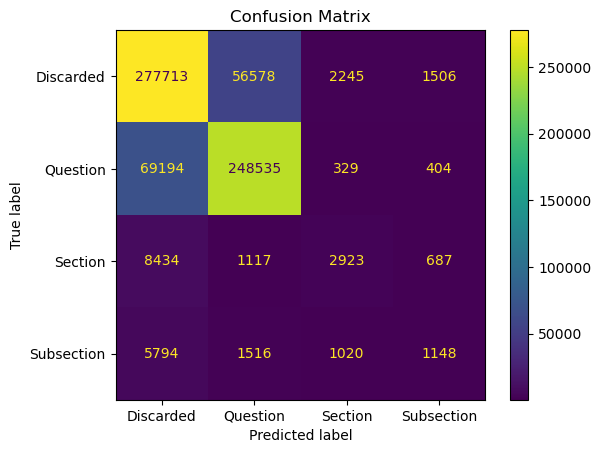

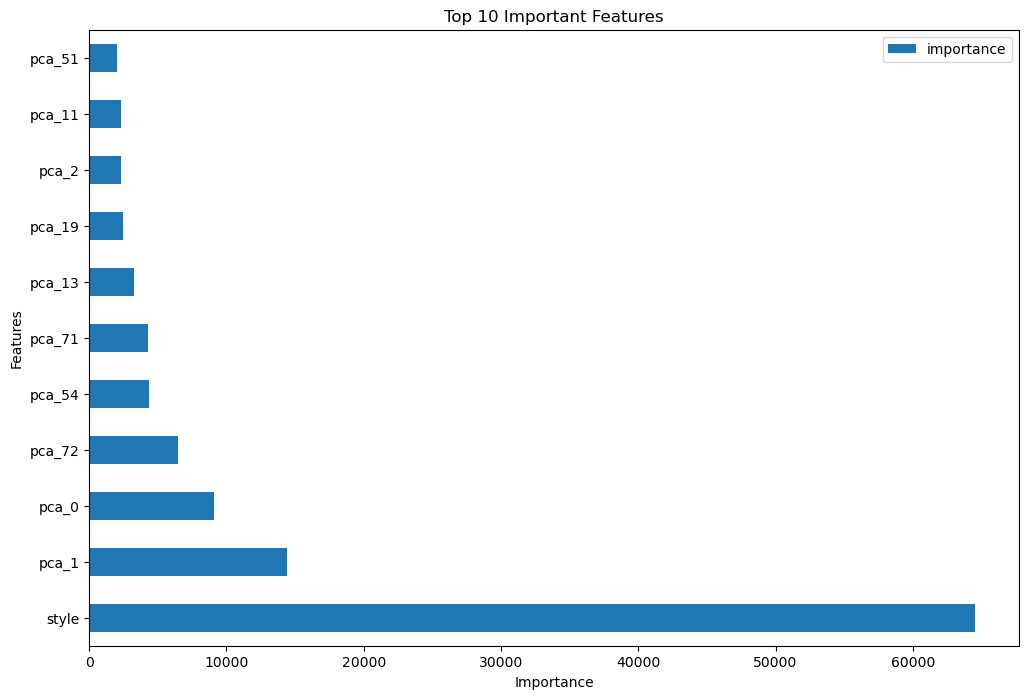

In [19]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import imblearn
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Prepare lists to hold performance metrics for each fold
f1_scores = []
classification_reports = []
feature_importances =[]

# Perform the 5-fold cross-validation
for r in r_state:
    train_set = train_df_dict[r]
    test_set = test_df_dict[r]
    
    # Initialize prediction array with -1
    final_predictions = np.full(len(test_set), -1)
    
    # First layer: Discarded vs Non-Discarded
    X_train = train_set.drop(columns=excluded_columns + excluded_columns_target)
    y_train = train_set['target_discarded']
    X_test = test_set.drop(columns=excluded_columns + excluded_columns_target)
    y_test = test_set['target_discarded']
    
    X_train['style'] = X_train['style'].astype('category')
    X_test['style'] = X_test['style'].astype('category')

    # Train the LightGBM model
    model_top = lgb.LGBMClassifier(eval_metric='auc', objective='binary', n_jobs=-1)
    model_top.fit(X_train, y_train, categorical_feature=['style'])
    
    # Make predictions on the test set
    y_pred_top = model_top.predict(X_test)
    # Store the classification report for the first layer
    report_top = classification_report(y_test, y_pred_top, output_dict=True)
    # Update final_predictions array
    final_predictions[y_pred_top == 1] = 0  # 0 represents discarded
    
    # Second layer: Question vs Non-Question
    non_discarded_mask = y_pred_top == 0
    X_test_non_discarded = X_test[non_discarded_mask].copy()  # Create an explicit copy
    y_test_non_discarded = test_set.loc[non_discarded_mask, 'target_question']
    
    X_train_non_discarded = train_set.loc[train_set['target_discarded'] != True].drop(columns=excluded_columns + excluded_columns_target)
    y_train_non_discarded = train_set.loc[train_set['target_discarded'] != True, 'target_question']

    X_train_non_discarded['style'] = X_train_non_discarded['style'].astype('category')
    X_test_non_discarded['style'] = X_test_non_discarded['style'].astype('category')
    
    model_second = lgb.LGBMClassifier(eval_metric='auc', objective='binary', n_jobs=-1)
    model_second.fit(X_train_non_discarded, y_train_non_discarded, categorical_feature=['style'])
    y_pred_second = model_second.predict(X_test_non_discarded)
    # Store the classification report for the second layer
    report_second = classification_report(y_test_non_discarded, y_pred_second, output_dict=True)
    
    
    # Update final_predictions array
    non_discarded_indices = np.where(non_discarded_mask)[0]
    final_predictions[non_discarded_indices[y_pred_second == 1]] = 1  # 1 represents question
    
    # Third layer: Section vs Non-Section (Subsection)
    non_question_mask = y_pred_second == 0
    X_test_non_question = X_test_non_discarded[non_question_mask].copy()  # Create an explicit copy
    y_test_non_question = test_set.loc[non_discarded_indices[non_question_mask], 'target_section']
    
    X_train_non_question = train_set.loc[
        (train_set['target_question'] != True) & (train_set['target_discarded'] != True)
    ].drop(columns=excluded_columns + excluded_columns_target)
    y_train_non_question = train_set.loc[
        (train_set['target_question'] != True) & (train_set['target_discarded'] != True),
        'target_section'
    ]
    
    X_train_non_question['style'] = X_train_non_question['style'].astype('category')
    X_test_non_question['style'] = X_test_non_question['style'].astype('category')
    
    model_third = lgb.LGBMClassifier(eval_metric='auc', objective='binary', n_jobs=-1)
    model_third.fit(X_train_non_question, y_train_non_question, categorical_feature=['style'])
    y_pred_third = model_third.predict(X_test_non_question)
    # Store the classification report for the third layer
    report_third = classification_report(y_test_non_question, y_pred_third, output_dict=True)
    # Update final_predictions array
    non_question_indices = non_discarded_indices[non_question_mask]
    final_predictions[non_question_indices[y_pred_third == 1]] = 2  # 2 represents section
    final_predictions[non_question_indices[y_pred_third == 0]] = 3  # 3 represents subsection
    
    # Create true labels array
    true_labels = np.where(test_set['target_discarded'], 0,
                   np.where(test_set['target_question'], 1,
                   np.where(test_set['target_section'], 2, 3)))
    
    # Calculate metrics
    f1 = f1_score(true_labels, final_predictions, average='weighted')
    f1_scores.append(f1)
    
    print(f"Fold {r} F1 Score: {f1}")

    # Generate classification report for this fold
    report = classification_report(true_labels, final_predictions, output_dict=True)
    classification_reports.append({
        'overall': report,
        'discarded': report_top,
        'question': report_second,
        'section': report_third
    })
    
    print(f"Fold {r} Classification Report:\n{classification_report(true_labels, final_predictions)}")

    # Get feature importance from the third layer model and store
    feature_importance = model_third.booster_.feature_importance(importance_type='gain')
    feature_names = model_third.booster_.feature_name()
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(10)
    feature_importances.append(feature_importance_df)



# Calculate the average F1 score across all folds
average_f1_score = np.mean(f1_scores)
print(f"Average F1 Score: {average_f1_score}")

# Add confusion matrix visualization
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, final_predictions)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Discarded', 'Question', 'Section', 'Subsection']).plot()
plt.title('Confusion Matrix')
plt.show()

# Combine feature importance dataframes
final_feature_importance = pd.concat(feature_importances).groupby('feature').mean().sort_values(by='importance', ascending=False)
final_feature_importance.plot(kind='barh', figsize=(12, 8))
plt.title('Top 10 Important Features')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [21]:
classification_reports[0]['section']

{'False': {'precision': 0.8352305065452476,
  'recall': 0.434686018957346,
  'f1-score': 0.5717903759984414,
  'support': 6752.0},
 'True': {'precision': 0.41920267802799754,
  'recall': 0.8263347330533893,
  'f1-score': 0.5562285483545326,
  'support': 3334.0},
 'accuracy': 0.5641483244100733,
 'macro avg': {'precision': 0.6272165922866225,
  'recall': 0.6305103760053676,
  'f1-score': 0.5640094621764871,
  'support': 10086.0},
 'weighted avg': {'precision': 0.6977095090956629,
  'recall': 0.5641483244100733,
  'f1-score': 0.5666463017009209,
  'support': 10086.0}}

In [23]:
import pandas as pd

# Function to convert classification report dictionary to DataFrame
def report_dict_to_df(report_dict):
    report_df = pd.DataFrame(report_dict).transpose()
    return report_df

# Convert each report to DataFrame
overall_report_df = report_dict_to_df(classification_reports[0])
discarded_report_df = report_dict_to_df(classification_reports[1])
question_report_df = report_dict_to_df(classification_reports[2])
section_report_df = report_dict_to_df(classification_reports[3])

# Add 'subsection' as the inverse of the section predictions
# subsection_metrics = {
    # 'precision': classification_reports[3][False]['precision'],
    # 'recall': classification_reports[3][False]['recall'],
    # 'f1-score': classification_reports[3][False]['f1-score'],
    # 'support': classification_reports[3][False]['support']
# }
# subsection_report_df = pd.DataFrame(subsection_metrics, index=['subsection'])

# Adding a layer column to identify the layer
overall_report_df['Layer'] = 'Overall'
discarded_report_df['Layer'] = 'Discarded'
question_report_df['Layer'] = 'Question'
section_report_df['Layer'] = 'Section'

# Combine all reports into a single DataFrame
consolidated_report_df = pd.concat([overall_report_df, discarded_report_df, question_report_df, section_report_df])

# Reorder the columns to make Layer the first column
# cols = ['Layer'] + [col for col in consolidated_report_df.columns if col != 'Layer']
# consolidated_report_df = consolidated_report_df[cols]

# Display the consolidated DataFrame
print(consolidated_report_df)


                                                           0  \
overall    {'precision': 0.7695736434108527, 'recall': 0....   
discarded                                                NaN   
question                                                 NaN   
section                                                  NaN   
overall    {'precision': 0.7710785381115555, 'recall': 0....   
discarded                                                NaN   
question                                                 NaN   
section                                                  NaN   
overall    {'precision': 0.7635840056399847, 'recall': 0....   
discarded                                                NaN   
question                                                 NaN   
section                                                  NaN   
overall    {'precision': 0.7763264989729081, 'recall': 0....   
discarded                                                NaN   
question                                

In [24]:
print(overall_report_df)

                                                           0  \
overall    {'precision': 0.7695736434108527, 'recall': 0....   
discarded                                                NaN   
question                                                 NaN   
section                                                  NaN   

                                                           1  \
overall    {'precision': 0.7802931673855262, 'recall': 0....   
discarded                                                NaN   
question                                                 NaN   
section                                                  NaN   

                                                           2  \
overall    {'precision': 0.41920267802799754, 'recall': 0...   
discarded                                                NaN   
question                                                 NaN   
section                                                  NaN   

                                     

In [25]:
classification_reports[1].items()

dict_items([('overall', {'0': {'precision': 0.7710785381115555, 'recall': 0.8148504749015226, 'f1-score': 0.7923604496935848, 'support': 330279.0}, '1': {'precision': 0.8024928946560551, 'recall': 0.7834788409664414, 'f1-score': 0.7928718890342022, 'support': 310293.0}, '2': {'precision': 0.4185430463576159, 'recall': 0.22314633189486072, 'f1-score': 0.29109518935516887, 'support': 12745.0}, '3': {'precision': 0.3246579017976925, 'recall': 0.13189448441247004, 'f1-score': 0.18758235795674755, 'support': 9174.0}, 'accuracy': 0.7793162473150579, 'macro avg': {'precision': 0.5791930952307297, 'recall': 0.4883425330438237, 'f1-score': 0.5159774715099259, 'support': 662491.0}, 'weighted avg': {'precision': 0.7728281878053853, 'recall': 0.7793162473150579, 'f1-score': 0.7745818475551577, 'support': 662491.0}}), ('discarded', {'False': {'precision': 0.8049179647996734, 'recall': 0.7594909274800429, 'f1-score': 0.7815448948774538, 'support': 332212.0}, 'True': {'precision': 0.7710785381115555,

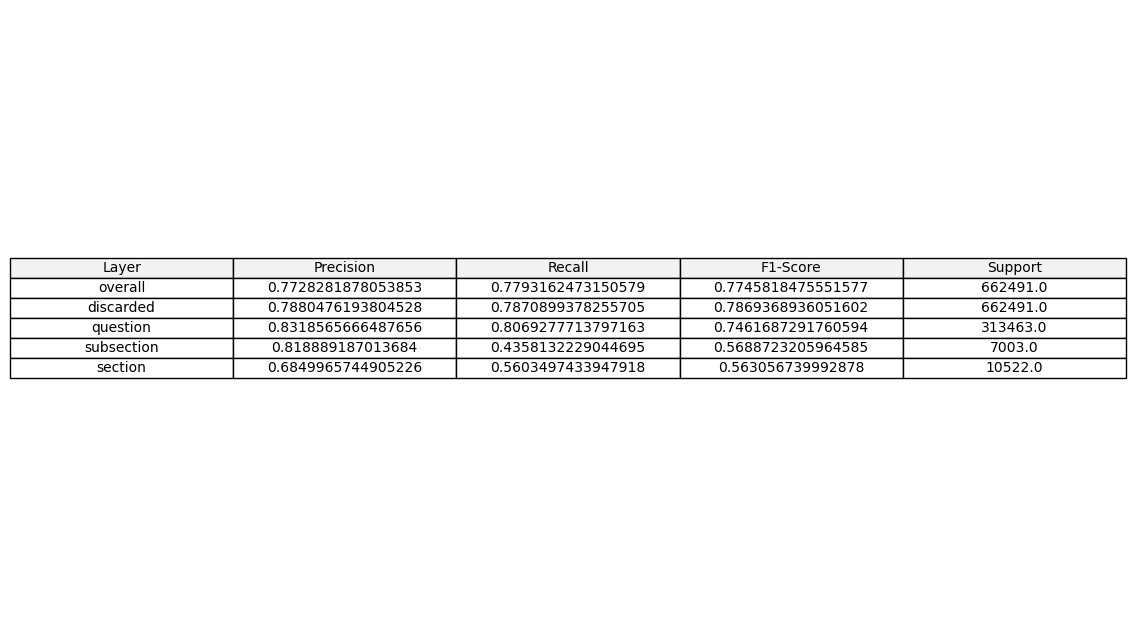

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the required metrics
data = []
for layer, report in classification_reports[1].items():
    if layer == 'section':  # For the third layer, add an extra row for 'subsection'
        subsection_metrics = report['False']
        data.append([
            'subsection',
            subsection_metrics['precision'], subsection_metrics['recall'], subsection_metrics['f1-score'], subsection_metrics['support']
        ])
    weighted_avg_metrics = report['weighted avg']
    data.append([
        layer,
        weighted_avg_metrics['precision'], weighted_avg_metrics['recall'], weighted_avg_metrics['f1-score'], weighted_avg_metrics['support']
    ])

# Create a DataFrame
columns = ['Layer', 'Precision', 'Recall', 'F1-Score', 'Support']
consolidated_report_df = pd.DataFrame(data, columns=columns)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the figure size as needed

# Hide the axis
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=consolidated_report_df.values, 
                 colLabels=consolidated_report_df.columns, 
                 cellLoc='center', 
                 loc='center', 
                 colColours=["#f2f2f2"] * consolidated_report_df.shape[1])

# Adjust the font size and table layout
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Display the plot
plt.show()
